In [ ]:
import monai
import shutil
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    Spacingd,
    RandWeightedCrop,
    RandRotate,
    RandFlip,
    Rand3DElasticd,
    RandRotated,
    LoadImage,
    EnsureChannelFirstd,
    Orientationd,
    EnsureChannelFirst,
    ScaleIntensityd,
    ScaleIntensity,
    RandFlipd)
import nibabel
import shutil
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, PersistentDataset, SmartCacheDataset, ThreadDataLoader
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.networks.blocks import Convolution
from monai.networks.nets import Discriminator, Generator
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping

import torchvision.transforms as transforms
import random

from torch.utils.data import DataLoader

from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

In [4]:
date="test" #  2e-5 learning rate, batch size 60, batch norm, mae loss func, 16 patch size
shutil.copy('/home/fogunsan/scratch/degad/repo/MRI-DeGad/src/6a-train_degad_CNN.py', f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/')
# copy current version of training script to folder date

'/home/fogunsan/scratch/degad/derivatives/UNET/test/6a-train_degad_CNN.py'

In [4]:
gad_t1= sorted(glob('/localscratch/tmp/passing_dataset/*/*_acq-gad_resampled_T1w.nii.gz'))# gad images who's corresponding nongad images underwent a rigid transform
nongad_t1= sorted(glob('/localscratch/tmp/normalized_fcm/*/*_acq-nongad_normalized_fcm.nii.gz')) # nongad images which underwent a rigid transform and underwent fcm normalization
image_dict = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(gad_t1,nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled
print(len(image_dict)) #0:30 & 30:36
train_files, validate_files, test_files = (image_dict[0:2] + image_dict[36:41:2]),(image_dict[30:32] + image_dict[37:42:2]), image_dict[42:47] #creates a list of dictionaries for each set (training, val, testing), with keys of gad and nongad in each index 

47


In [8]:
## now caching before and after patching
num_train_files = len(train_files)
num_validate_files = len(validate_files)
num_patches =6#patches per image if changing to 16,16,16 need 1200*8 patches to keep same amount of data but would increase loading time
batch_size = 2
date = "test" # set to current day to not overwrite previous models or test if just testing
training_steps = int(num_train_files * num_patches / batch_size) # number of training steps per epoch
validation_steps = int(num_validate_files * num_patches / batch_size) # number of validation steps per epoch

patching_func= Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        Orientationd(keys=("image", "label"), axcodes="SPL"),
        ScaleIntensityd(keys = ["image"], minv=0.0, maxv=1.0),
        RandCropByPosNegLabeld(# gonna use this function to create patches
            keys = ["image", "label"],
            label_key = "image",
            spatial_size=(32,32,32),
            pos = 1,
            neg = 0.01, # 1
            num_samples= num_patches# CHANGE BACK TO 5000
        )
    ])
patch_transforms = Compose([Rand3DElasticd(keys =["image", "label"], sigma_range = (0.5,1), magnitude_range = (0.1, 0.3), prob=0.2, shear_range=(0.1, -0.05, 0.0, 0.0, 0.0, 0.0), scale_range=0.5, padding_mode= "zeros"),
          RandFlipd(keys =["image", "label"], prob = 0.4, spatial_axis=1)])
    #RandRotated(keys =["image", "label"], range_x = 0.8, range_y = 0.8, range_z = 0.8, prob = 0.4), 
    #RandFlipd(keys =["image", "label"], prob = 0.2, spatial_axis=1)])
# flipping along y-axis (horizontally), using small SD range for blurring kernel for the warp, 
train_patches_dataset = PatchDataset(data = train_files, patch_func=patching_func, samples_per_image=num_patches, transform= patch_transforms)
validate_patches_dataset = PatchDataset(data = validate_files, patch_func=patching_func, samples_per_image=num_patches) 

train_patches_dataset = CacheDataset(data=train_patches_dataset, cache_rate=1, num_workers=1) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=validate_patches_dataset,  cache_rate=1, num_workers=1)



#setting num_workers >1 causes transforms error later on in training loop

Loading dataset: 100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


In [18]:
CNN=UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32,64,128,256,512,512,512),
            strides=(2, 2, 2, 2,1,1,1),
            dropout= 0.2,
            norm = Norm.BATCH
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init)
CNN_model = CNN.to(device)


NameError: name 'Norm' is not defined

In [7]:
import time
learning_rate = 2e-5 # changed from 2e-4
betas = (0.5, 0.999)
cnn_opt = torch.optim.Adam(CNN_model.parameters(), lr = learning_rate, betas=betas)

patience = 1# epochs it will take for training to terminate if no improvement
early_stopping = EarlyStopping(patience=patience, verbose=True, path = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt')
start = time.time() # initializing variable to calculate training time

max_epochs = 4000 # max total iterations over entire training set
#root_mean_squared = MeanSquaredError(squared = False).to(device) #rmse metric calculated at the end of each epoch for training and val
mean_abs_error = torch.nn.L1Loss().to(device)
#SSIM_L = SSIM(gaussian_kernel=True, sigma=1.5, reduction='elementwise_mean').to(device)

mae_val = [0] # list of validation loss calculated at the end of each epoch
epoch_loss_values = [0] # list of training loss calculated at the end of each epoch

train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=True, num_workers = 16)
val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=True, num_workers =16)

for epoch in range(max_epochs):
    CNN_model.train() # setting model to training mode
    epoch_loss = 0 # total traininig loss in an epoch
    progress_bar(
            index=epoch+1, # displays what step we are of current epoch, our epoch number, training  loss
            count = max_epochs, 
            desc= f"epoch {epoch + 1}, training mae loss: {epoch_loss_values[-1]:.4f}, validation mae metric: {mae_val[-1]:.4f}",
            newline = True) # progress bar to display current stage in training
    for i,train_batch in enumerate(train_loader): # iterating through dataloader
        gad_images = train_batch['image'].cuda()# gad images of batch
        nongad_images = train_batch['label'].cuda() # nongad images of batch
        cnn_opt.zero_grad()
        degad_images = CNN_model(gad_images) # feeding CNN with gad images
        #MAE_loss = mean_abs_error(degad_images, nongad_images)
        #SSIM_loss = 1- SSIM_L(degad_images, nongad_images) # want to maximize SSIM loss so subtract from 1
        #train_loss= 0.5*MAE_loss + 0.35*SSIM_loss
        train_loss = mean_abs_error(degad_images, nongad_images)
        train_loss.backward()
        cnn_opt.step()
        epoch_loss += train_loss.item() # adding loss for this batch to the total training loss for this epoch
    avg_training_loss = epoch_loss / training_steps
    epoch_loss_values.append(avg_training_loss) # append total epoch loss divided by the number of training steps in epoch to loss list
    CNN_model.eval() #setting model to evaluation mode for validation
    with torch.no_grad(): #we do not update weights/biases in validation training, only used to assess current state of model
        mae_total_epoch = 0 # mean absolute error for the entire epoch
        for i,val_batch in enumerate(val_loader): # iterating through dataloader
            gad_images =val_batch["image"].cuda()# batch with gad images
            nongad_images = val_batch["label"].cuda() # batch with nongad images
            degad_images = CNN_model(gad_images)
            #MAE_loss = mean_abs_error(degad_images, nongad_images)
            #SSIM_loss = 1- SSIM_L(degad_images, nongad_images)
            #val_loss= 0.5*MAE_loss + 0.35*SSIM_loss
            val_loss = mean_abs_error(degad_images, nongad_images)
            mae_total_epoch += val_loss # adding val mse of this batch to total val epoch mse
        avg_val_mae = mae_total_epoch.item()/validation_steps
        mae_val.append(avg_val_mae) # dividing total mse in this epoch by the number of batches -> add to list of epoch mse
        early_stopping(avg_val_mae, CNN_model) # early stopping is based on the average validation mse for an epoch, keeps track of last best model
        
    if early_stopping.early_stop:
        print("Early stopping") # stops early if validation mae has not improved for 100 epochs
        break
    

end = time.time()
time = end - start
print(time)


NameError: name 'train_patches_dataset' is not defined

In [ ]:
with open (f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/model_stats.txt', 'w') as file:  
    file.write(f'training time: {time}\n')  
    file.write(f'training loss: {epoch_loss_values[-100]} validation loss: {early_stopping.val_loss_min}')

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(list(range(len(epoch_loss_values))), epoch_loss_values, label="Training Loss")
plt.plot(list(range(len(mae_val))), mae_val , label="Validation Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/lossfunction.png')


In [9]:
CNN_model.load_state_dict(torch.load(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint_251.pt'))
CNN_model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(64

In [10]:
# running inference on only one test subject
inference_transforms = Compose( #loading full image
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys = ["image"], minv=0.0, maxv=1.0)])# applying min max normalization only on gad images
        

infer_ds = Dataset(data=test_files[0:2], transform=inference_transforms) 
infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=True) #using pytorch's dataloader



In [11]:
degad_imgs = []
gad_infer_imgs = []
nongad_infer_imgs = []
for infer_imgs in infer_loader:
    gad_infer_imgs.append(infer_imgs["image"])
    nongad_infer_imgs.append(infer_imgs["label"])
    output_degad_img = sliding_window_inference(inputs = infer_imgs["image"].to('cpu'), roi_size = (32,32,32), sw_batch_size= 5, predictor = CNN_model.to('cpu'), overlap = 0.25, mode = "gaussian", sw_device= 'cuda', device = 'cpu', progress = True )
    degad_imgs.append(output_degad_img)

100%|██████████| 170/170 [00:46<00:00,  3.62it/s]


In [13]:
for i in range(len(degad_imgs)): #looping thru number of output files
    degad_img =degad_imgs[i][0][0] # reshaping to exclude batch and channels (only one channel)
    gad_image= nibabel.load(test_files[i]["image"]) # getting original gad image back to compare to 
    gad_image_file = test_files[i]["image"]
    print(gad_image_file)
    sub = os.path.basename(gad_image_file).split("_")[0]
    degad_name = f'{sub}_acq-degad_T1w.nii.gz'
    degad_file = nibabel.Nifti1Image(degad_img.detach().numpy(), affine= None,header= gad_image.header) # with same header as inference gad 
    output_dir = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test'
    os.makedirs(f'{output_dir}/bids/{sub}/ses-pre/anat', exist_ok=True)# save in bids format
    output_path = f'{output_dir}/bids/{sub}/ses-pre/anat/{degad_name}'
    nibabel.save(degad_file,output_path) 

/localscratch/tmp/passing_dataset/sub-P051/sub-P051_acq-gad_resampled_T1w.nii.gz
/localscratch/tmp/passing_dataset/sub-P052/sub-P052_acq-gad_resampled_T1w.nii.gz


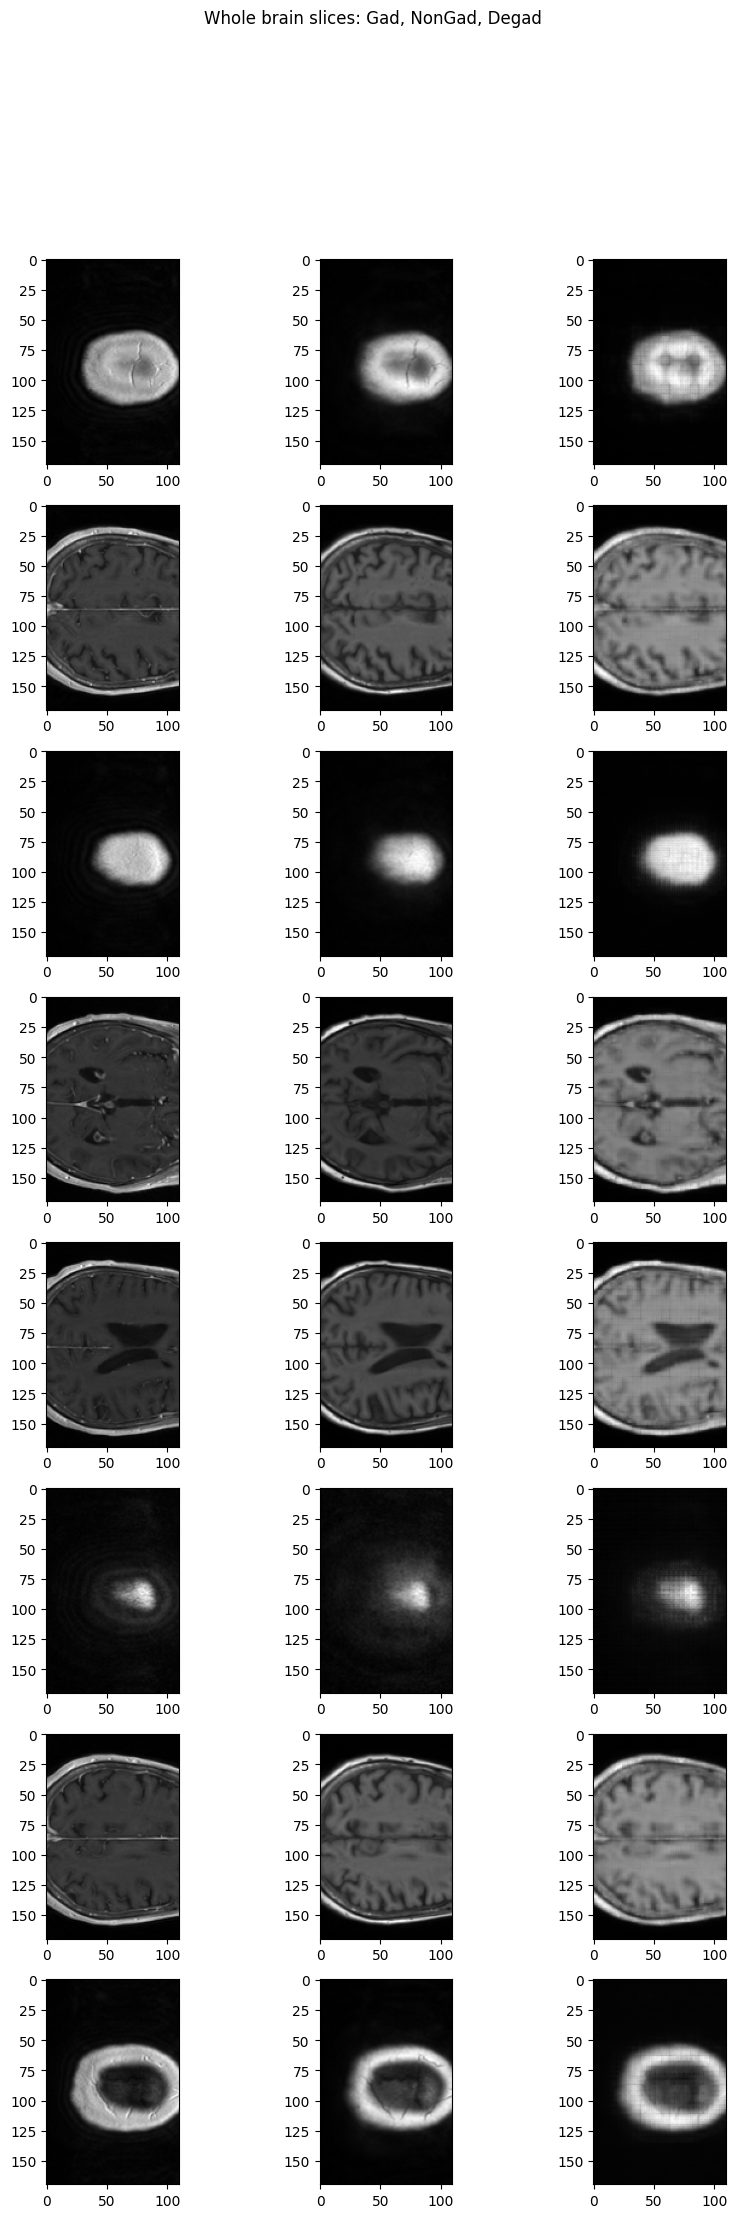

In [14]:
import random
## generating random whole brain slices
fig, axes = plt.subplots(8, 3,figsize=(10,25))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    plt.subplot(8, 3, i)
    x = random.randint(80, 190)
    plt.imshow(gad_infer_imgs[0][0, 0,40:210 ,40:150, x].cpu().data.numpy(), cmap ="gray")
    
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, 40:210 , 40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, 40:210,40:150, x].cpu().data.numpy(), "gray")

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test/figure_whole_brain.png')

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


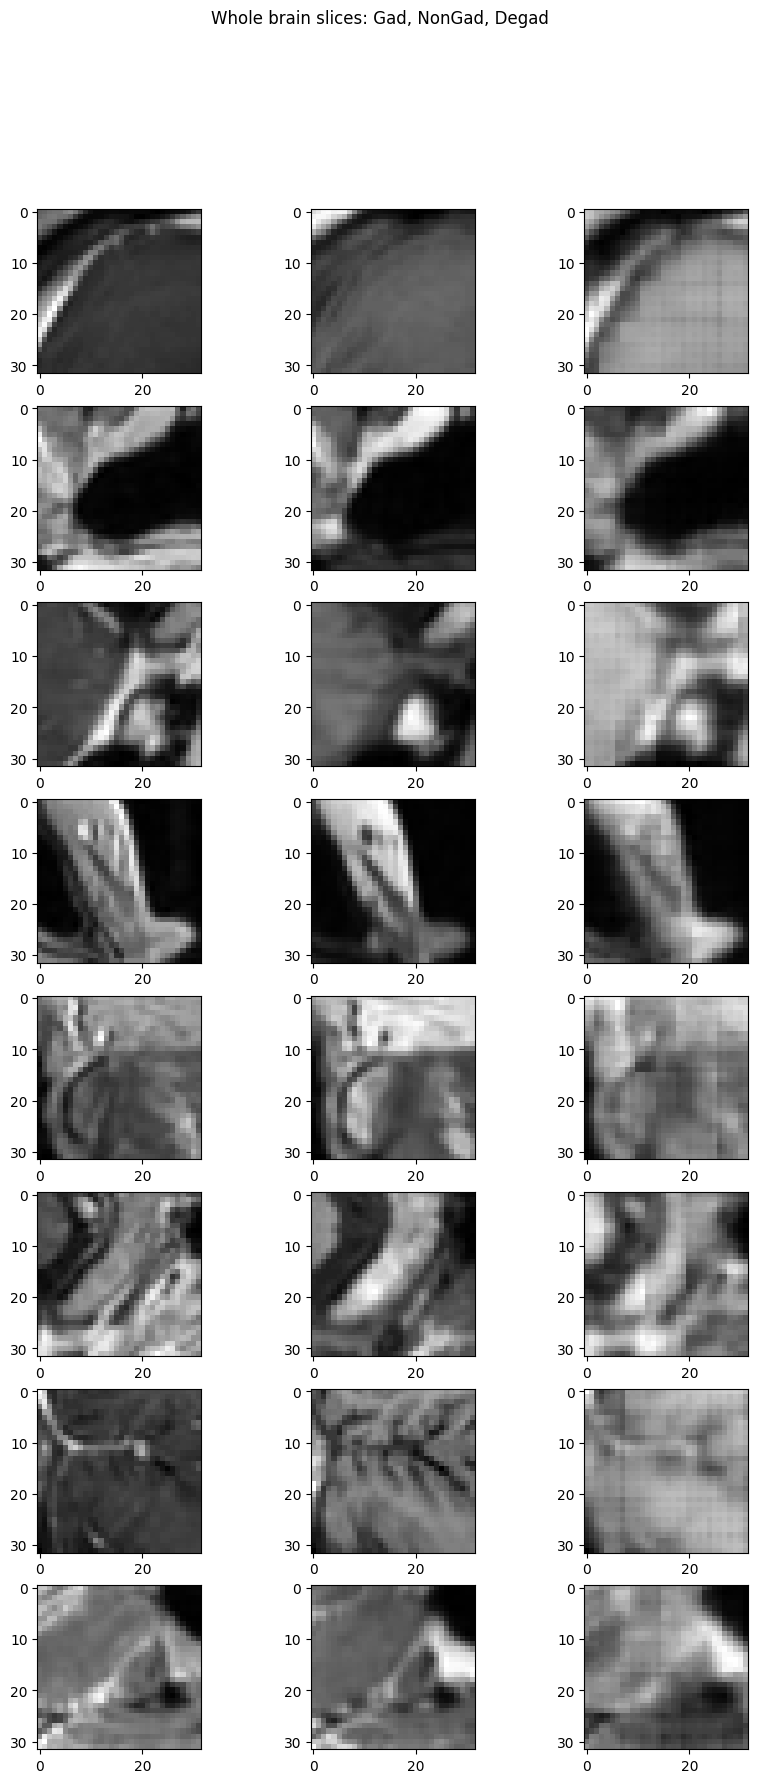

In [15]:
#generating random 32x32 slices
fig, axes = plt.subplots(8, 4,figsize=(10,20))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    
    x = random.randint(40, 190)
    y = random.randint(40, 190)
    z = random.randint(40, 190)
    plt.subplot(8, 3, i)
    plt.imshow(gad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), cmap ="gray")
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, x:x+32,y:y+32,50].cpu().data.numpy(), "gray")
   

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test/figure_32_patches.png')  